In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Module 4: Car Model

This module is divided into two parts: a velocity model and a steering model. By the end of the module, you will have created Python code that simulates the car's movement based on a physics models and calibrated by real-world data.

Using the velocity model, you will be able to predict the car's velocity based on the throttle and time. Using the steering model, you will be able to predict the car's steering angle based on the steering wheel angle and time. This will enable you to plan what commands to send to the car to make it move to a desired location.

## Velocity Model

### Forces Acting on the RC Car

Consider an RC car of mass \( m \) moving on a flat surface. The primary forces acting on the car are:

- \( F_motor \): The driving force provided by the motor.
- \( F_friction \): The frictional force opposing the motion, which is proportional to the velocity, \( F_friction = -b v \), where \( b \) is the friction coefficient.
- \( F_air \): The air resistance, which is proportional to the square of the velocity, \( F_air = -c v^2 \), where \( c \) is the air resistance coefficient.

The net force acting on the car can be expressed as:


$$ F_{\text{net}} = F_{\text{motor}} - b v - c v^2 $$

### Newton's Second Law of Motion

According to Newton's second law, the net force acting on the car is equal to the mass of the car times its acceleration:

$$ F_{\text{net}} = m \frac{dv}{dt} $$

Substituting the expression for \( F_net \):

$$ m \frac{dv}{dt} = F_{\text{motor}} - b v - c v^2 $$

### Velocity as a Function of Time

To find the velocity as a function of time, solve the differential equation:

$$ \frac{dv}{dt} = \frac{F_{\text{motor}}}{m} - \frac{b}{m} v - \frac{c}{m} v^2 $$

This is a nonlinear differential equation due to the \( v^2 \) term. However, if air resistance is small compared to friction, you can neglect the \( c v^2 \) term for a simplified model:

$$ \frac{dv}{dt} = \frac{F_{\text{motor}}}{m} - \frac{b}{m} v $$

The solution to this first-order linear differential equation is:

$$ v(t) = \frac{F_{\text{motor}}}{b} \left(1 - e^{-\frac{b}{m}t}\right) $$

This equation describes how the velocity of the car approaches a terminal velocity \( F_motor/b \) as time increases.

### Terminal Velocity

The terminal velocity \( v_terminal\) is reached when the acceleration \( dv/d \) becomes zero:

$$ v_{\text{terminal}} = \frac{F_{\text{motor}}}{b} $$

## Implementing the Velocity Model
For now we will assume that you only use one motor command to drive, so that there is only one F_motor. The constants that are given are selected randomly and are not accurate. You will need to calibrate these constants using your own car.

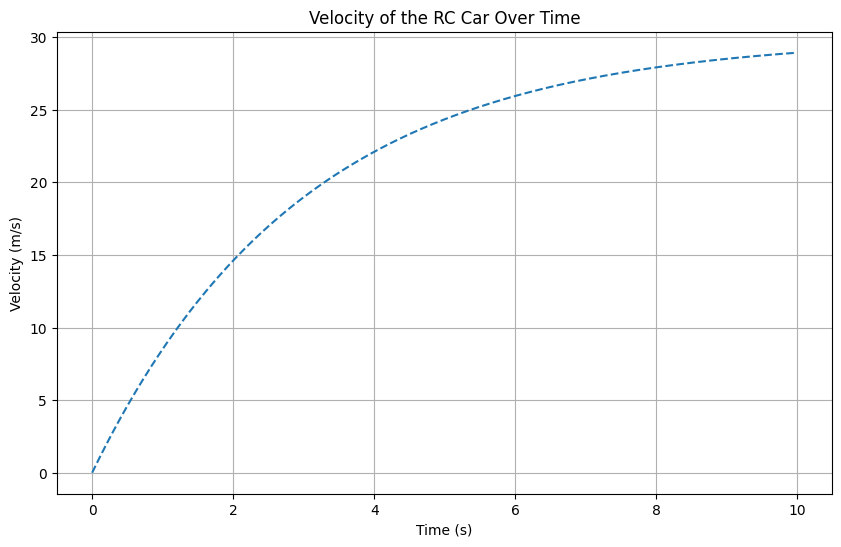

In [2]:
# Parameters
m = 1.5  # mass of the car (kg)
F_motor = 15.0  # constant motor force (N)
b = 0.5  # friction coefficient (N·s/m)

dt = 0.01  # time step (s)
t_max = 10.0  # maximum simulation time (s)

# Time array
t = np.arange(0, t_max, dt)

# Velocity array
v = np.zeros_like(t)

# Initial condition
v[0] = 0.0  # initial velocity (m/s)

# Numerical simulation (Euler's method)
for i in range(1, len(t)):
    # Simplified model (without air resistance)
    dv_simplified = (F_motor/m - (b/m) * v[i-1]) * dt
    v[i] = v[i-1] + dv_simplified

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, v, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity of the RC Car Over Time')
plt.grid(True)
plt.show()
    